In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import random
from collections import defaultdict
import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from efficientnet_pytorch import EfficientNet
import torch.utils.checkpoint as checkpoint
from torch.amp import GradScaler
from torch.amp import autocast

from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as TF
from torchvision.models import efficientnet_b3, efficientnet_b4, regnet_y_8gf
from torchvision.models.detection.backbone_utils import BackboneWithFPN

from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torchvision.models._utils import IntermediateLayerGetter

from sklearn.metrics import confusion_matrix, classification_report
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(42)

d:\DS_repo\Sweet-Chili\global-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Load category names dynamically from COCO annotation files
def load_category_names(annotation_files):
    category_map = {}
    for ann_file in annotation_files:
        with open(ann_file, 'r') as f:
            data = json.load(f)
            for cat in data.get('categories', []):
                category_map[cat['id']] = cat['name']
    return category_map

train_ann_path = "D:/DS_repo/Sweet-Chili/dataset/annotations/instance-train.json"
val_ann_path = "D:/DS_repo/Sweet-Chili/dataset/annotations/instances-val.json"

CATEGORY_NAMES = load_category_names([train_ann_path, val_ann_path])
NUM_CLASSES = len(CATEGORY_NAMES) + 1

In [3]:
class CocoDataset(Dataset):    
    def __init__(self, img_dir, ann_file, transforms=None, category_names=None):
        self.img_dir = img_dir
        self.transforms = transforms

        with open(ann_file, 'r') as f:
            self.coco_data = json.load(f)
        
        self.category_names = category_names or CATEGORY_NAMES
        self.category_id_to_idx = {cat_id: idx for idx, cat_id in enumerate(self.category_names.keys())}
        self.img_annotations = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.img_annotations[ann['image_id']].append(ann)

        self.images = [img for img in self.coco_data['images'] 
                      if img['id'] in self.img_annotations and 
                      len(self.img_annotations[img['id']]) > 0]
        
        print(f"Loaded {len(self.images)} images with annotations")
        self._analyze_dataset()
    
    def _analyze_dataset(self):
        """Analyze dataset distribution"""
        class_counts = defaultdict(int)
        total_annotations = 0
        
        for img in self.images:
            annotations = self.img_annotations[img['id']]
            total_annotations += len(annotations)
            
            for ann in annotations:
                cat_id = ann['category_id']
                if cat_id in self.category_names:
                    class_counts[self.category_names[cat_id]] += 1
        
        print(f"Total annotations: {total_annotations}")
        print("Class distribution:")
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        try:
            image = Image.open(img_path).convert('RGB')
            image = np.array(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = np.zeros((1000, 1000, 3), dtype=np.uint8)

        annotations = self.img_annotations[img_info['id']]

        boxes = []
        labels = []
        masks = []
        areas = []
        
        for ann in annotations:
            if ann['category_id'] not in self.category_names:
                continue

            bbox = ann['bbox']
            x, y, w, h = bbox
            boxes.append([x, y, x + w, y + h])
            
            label_idx = self.category_id_to_idx[ann['category_id']] + 1
            labels.append(label_idx)
            
            mask = self._create_mask(ann['segmentation'], img_info['height'], img_info['width'])
            masks.append(mask)
            
            areas.append(ann['area'])
        
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, image.shape[0], image.shape[1]), dtype=torch.uint8)
            areas = torch.zeros((0,), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)
            areas = torch.as_tensor(areas, dtype=torch.float32)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_info['id']]),
            'area': areas,
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64)
        }
        
        if self.transforms:
            if isinstance(image, np.ndarray):
                image_pil = Image.fromarray(image)
            else:
                image_pil = image
            
            transformed = self.transforms(image=np.array(image_pil))
            image = transformed['image']
        else:
            image = TF.to_tensor(image)
        
        return image, target
    
    def _create_mask(self, segmentation, height, width):
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for seg in segmentation:
            if len(seg) >= 6:
                poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                cv2.fillPoly(mask, [poly], 1)
        
        return mask

In [4]:
def get_train_transforms():
    return A.Compose([
        A.LongestMaxSize(max_size=1000, p=1.0),
        A.PadIfNeeded(min_height=1000, min_width=1000, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
        
        # Geometric augmentations
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.Rotate(limit=15, p=0.4),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.4),
        
        # Color augmentations
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15, p=0.5),
        A.CLAHE(clip_limit=2.0, p=0.3),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.4),
        
        # Weather variations
        # A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, p=0.2),
        # A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1, p=0.1),
        
        # Noise and blur
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        # A.OneOf([
        #     A.MotionBlur(blur_limit=3, p=0.3),
        #     A.MedianBlur(blur_limit=3, p=0.3),
        #     A.GaussianBlur(blur_limit=3, p=0.3),
        # ], p=0.2),
        
        A.CoarseDropout(max_holes=8, max_height=50, max_width=50, p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_val_transforms():
    return A.Compose([
        A.LongestMaxSize(max_size=1000, p=1.0),
        A.PadIfNeeded(min_height=1000, min_width=1000, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [5]:
train_transforms = get_train_transforms()
val_transforms = get_val_transforms()

train_ann_path = "D:/DS_repo/Sweet-Chili/dataset/annotations/instance-train.json"
val_ann_path = "D:/DS_repo/Sweet-Chili/dataset/annotations/instances-val.json"

train_dataset = CocoDataset(
    "D:/DS_repo/Sweet-Chili/dataset/images/train", 
    train_ann_path, 
    transforms=train_transforms,
    category_names=CATEGORY_NAMES
)

val_dataset = CocoDataset(
    "D:/DS_repo/Sweet-Chili/dataset/images/val", 
    val_ann_path, 
    transforms=val_transforms,
    category_names=CATEGORY_NAMES
)

C:\Users\worka\AppData\Local\Temp\ipykernel_3816\2559712428.py:4: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=1000, min_width=1000, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),
d:\DS_repo\Sweet-Chili\global-env\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\worka\AppData\Local\Temp\ipykernel_3816\2559712428.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
C:\Users\worka\AppData\Local\Temp\ipykernel_3816\2559712428.py:31: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=50, max_width=50, p=0.2),
C:\Users\worka\AppData\Local\Temp\ipykernel_3816\2559712428.py:39: UserWarning: Argument(s) 'val

Loaded 1100 images with annotations
Total annotations: 1102
Class distribution:
  Bacterial Spot: 100
  Cercospora Spot: 100
  Curl Virus: 101
  Dry chili: 100
  Flower: 100
  Green chili: 100
  Healthy Leaf: 100
  Nutrition Deficiency: 100
  Red chili: 100
  Rotten chili: 100
  White Spot: 101
Loaded 275 images with annotations
Total annotations: 276
Class distribution:
  Bacterial Spot: 25
  Cercospora Spot: 25
  Curl Virus: 25
  Dry chili: 25
  Flower: 25
  Green chili: 25
  Healthy Leaf: 25
  Nutrition Deficiency: 25
  Red chili: 26
  Rotten chili: 25
  White Spot: 25


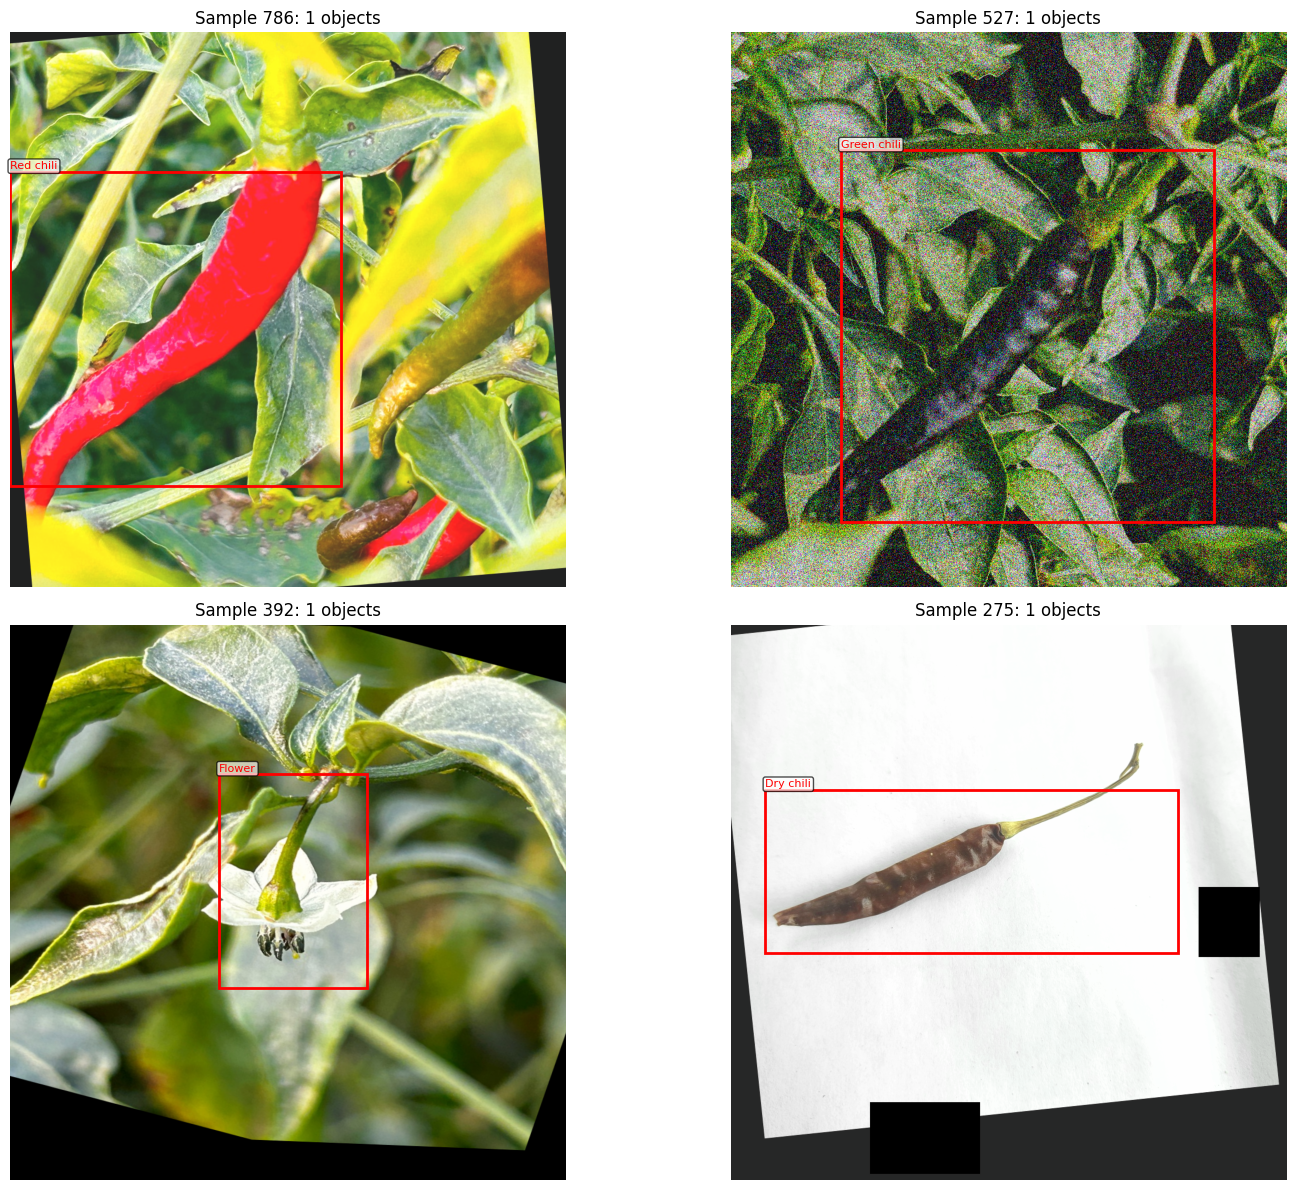

In [6]:
def visualize_dataset_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx, ax in enumerate(axes):
        if idx < len(indices):
            image, target = dataset[indices[idx]]
            
            # Convert tensor to numpy if needed
            if isinstance(image, torch.Tensor):
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = image.permute(1, 2, 0).numpy()
                image_np = std * image_np + mean
                image_np = np.clip(image_np, 0, 1)
            else:
                image_np = image
            
            ax.imshow(image_np)
            
            # Draw annotations
            boxes = target['boxes'].numpy()
            labels = target['labels'].numpy()
            
            for box, label in zip(boxes, labels):
                x1, y1, x2, y2 = box
                rect = plt.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    fill=False, color='red', linewidth=2
                )
                ax.add_patch(rect)
                
                class_name = list(CATEGORY_NAMES.values())[label-1] if label > 0 else 'Background'
                ax.text(x1, y1-5, class_name, color='red', fontsize=8,
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))
            
            ax.set_title(f'Sample {indices[idx]}: {len(boxes)} objects')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_dataset_samples(train_dataset, num_samples=4)

In [7]:
class EfficientNetBackbone(nn.Module):
    def __init__(self, model_name='efficientnet_b3', pretrained=True):
        super().__init__()
        
        if model_name == 'efficientnet_b3':
            self.backbone = efficientnet_b3(pretrained=pretrained)
        elif model_name == 'efficientnet_b4':
            self.backbone = efficientnet_b4(pretrained=pretrained)
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        self.backbone.classifier = nn.Identity()
        
        if model_name == 'efficientnet_b3':
            self.out_channels = [40, 112, 320, 1536] 
        else: # efficientnet_b4
            self.out_channels = [56, 160, 448, 1792]
        
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=self.out_channels,
            out_channels=256
        )
        
    def forward(self, x):
        features = {}
        
        x = self.backbone.features[0](x)
        x = self.backbone.features[1](x)
        features['0'] = self.backbone.features[2](x)

        x = self.backbone.features[3](features['0'])
        features['1'] = self.backbone.features[4](x)

        x = self.backbone.features[5](features['1'])
        features['2'] = self.backbone.features[6](x)

        x = self.backbone.features[7](features['2'])
        features['3'] = self.backbone.features[8](x)
        
        fpn_features = self.fpn(features)
        
        return fpn_features
    
class RegNetBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        self.backbone = regnet_y_8gf(pretrained=pretrained)
        self.backbone.fc = nn.Identity()
        
        self.out_channels = [224, 448, 896, 2016]
        
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=self.out_channels,
            out_channels=256
        )
        
    def forward(self, x):
        features = {}
        
        x = self.backbone.stem(x)
        
        for i, stage in enumerate([self.backbone.trunk_output.block1,
                                  self.backbone.trunk_output.block2,
                                  self.backbone.trunk_output.block3,
                                  self.backbone.trunk_output.block4]):
            x = stage(x)
            features[str(i)] = x
        
        fpn_features = self.fpn(features)
        
        return fpn_features
    
# def create_enhanced_maskrcnn(num_classes, backbone_type='resnet50', pretrained=True):
#     """Create enhanced Mask R-CNN"""
    
#     if backbone_type == 'resnet50':
#         model = maskrcnn_resnet50_fpn(pretrained=pretrained)
        
#     elif backbone_type == 'efficientnet_b3':
#         backbone = EfficientNetBackbone('efficientnet_b3', pretrained=pretrained)
        
#         anchor_generator = AnchorGenerator(
#             sizes=((32, 64, 128, 256, 512),),
#             aspect_ratios=((0.5, 1.0, 2.0),) * 5
#         )
        
#         roi_pooler = MultiScaleRoIAlign(
#             featmap_names=['0', '1', '2', '3'],
#             output_size=7,
#             sampling_ratio=2
#         )
        
#         mask_roi_pooler = MultiScaleRoIAlign(
#             featmap_names=['0', '1', '2', '3'],
#             output_size=14,
#             sampling_ratio=2
#         )
        
#         model = MaskRCNN(
#             backbone,
#             num_classes=num_classes,
#             rpn_anchor_generator=anchor_generator,
#             box_roi_pool=roi_pooler,
#             mask_roi_pool=mask_roi_pooler
#         )
    
#     # Replace classifier heads
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(
#         in_features_mask, hidden_layer, num_classes
#     )
    
#     return model

def create_enhanced_maskrcnn(num_classes, backbone_type='resnet50', weights=MaskRCNN_ResNet50_FPN_Weights):
    if backbone_type == 'resnet50':
        model = maskrcnn_resnet50_fpn(pretrained=weights)
        
    elif backbone_type == 'efficientnet_b3':
        backbone = EfficientNetBackbone('efficientnet_b3', weights=efficientnet_b3)
        
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5
        )
        
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2
        )
        
        mask_roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=14,
            sampling_ratio=2
        )
        
        model = MaskRCNN(
            backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
            mask_roi_pool=mask_roi_pooler
        )
        
    elif backbone_type == 'regnet':
        backbone = RegNetBackbone(weights=regnet_y_8gf)
        
        anchor_generator = AnchorGenerator(
            sizes=((32, 64, 128, 256, 512),),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5
        )
        
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2
        )
        
        mask_roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=14,
            sampling_ratio=2
        )
        
        model = MaskRCNN(
            backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
            mask_roi_pool=mask_roi_pooler
        )
    
    else:
        raise ValueError(f"Unsupported backbone: {backbone_type}")
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )
    
    return model

In [10]:
model = create_enhanced_maskrcnn(
    num_classes=NUM_CLASSES,
    backbone_type='resnet50',  # efficientnet_b3 / resnet50 / regnet
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Move to device
model = model.to(device)

# Setup data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    # num_workers=8,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    # num_workers=8,
    collate_fn=collate_fn,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

d:\DS_repo\Sweet-Chili\global-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DS_repo\Sweet-Chili\global-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model parameters: 43,976,215
Train batches: 550
Val batches: 138


In [ ]:
# Setup optimizer with differential learning rates
backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if 'backbone' in name:
        backbone_params.append(param)
    else:
        head_params.append(param)

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 0.0001},
    {'params': head_params, 'lr': 0.001}
], weight_decay=1e-4)

# Cosine annealing with warmup
num_epochs = 10
warmup_epochs = 5

def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs
    else:
        return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f"Optimizer: AdamW with differential learning rates")
print(f"Scheduler: Cosine annealing with {warmup_epochs} warmup epochs")

Optimizer: AdamW with differential learning rates
Scheduler: Cosine annealing with 5 warmup epochs


In [12]:
class ChiliTrainer:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        
    def train_epoch(self, dataloader, optimizer, scheduler=None):
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        
        for batch_idx, (images, targets) in enumerate(dataloader):
            images = [img.to(self.device) for img in images]
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
            
            loss_dict = self.model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += losses.item()
            num_batches += 1
            
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(dataloader)}, Loss: {losses.item():.4f}")
        
        if scheduler:
            scheduler.step()
            
        return epoch_loss / num_batches
    
    def validate_epoch(self, dataloader):
        self.model.train()
        epoch_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for images, targets in dataloader:
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                
                loss_dict = self.model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                epoch_loss += losses.item()
                num_batches += 1
        
        return epoch_loss / num_batches

# Initialize trainer
trainer = ChiliTrainer(model, device)

In [13]:
# Create checkpoint directory
os.makedirs('./checkpoints', exist_ok=True)

print(f"Starting training for {num_epochs} epochs...")
print(f"Device: {device}")

best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    # Training
    train_loss = trainer.train_epoch(train_loader, optimizer)
    trainer.train_losses.append(train_loss)
    
    # Validation
    val_loss = trainer.validate_epoch(val_loader)
    trainer.val_losses.append(val_loss)
    
    # Step the scheduler with validation loss
    scheduler.step(val_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'category_names': CATEGORY_NAMES
        }, './checkpoints/best_model.pth')
        print(f"Best model saved! Val Loss: {val_loss:.4f}")
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': trainer.train_losses,
            'val_losses': trainer.val_losses,
            'category_names': CATEGORY_NAMES
        }, f'./checkpoints/checkpoint_epoch_{epoch+1}.pth')

print("\nTraining completed!")

Starting training for 50 epochs...
Device: cuda

Epoch 1/50
------------------------------
Batch 0/550, Loss: 5.0135
Batch 10/550, Loss: 5.2290
Batch 20/550, Loss: 4.1664
Batch 30/550, Loss: 3.6268
Batch 40/550, Loss: 3.8588
Batch 50/550, Loss: 4.6777
Batch 60/550, Loss: 5.0761
Batch 70/550, Loss: 3.6028
Batch 80/550, Loss: 4.7584
Batch 90/550, Loss: 4.8656
Batch 100/550, Loss: 5.1329
Batch 110/550, Loss: 4.0089
Batch 120/550, Loss: 4.9812
Batch 130/550, Loss: 4.7757
Batch 140/550, Loss: 4.2798
Batch 150/550, Loss: 5.1224
Batch 160/550, Loss: 4.6054
Batch 170/550, Loss: 5.3324
Batch 180/550, Loss: 4.8299
Batch 190/550, Loss: 4.2723
Batch 200/550, Loss: 5.1866
Batch 210/550, Loss: 3.6671
Batch 220/550, Loss: 5.2775
Batch 230/550, Loss: 3.9895
Batch 240/550, Loss: 3.7204
Batch 250/550, Loss: 5.0228
Batch 260/550, Loss: 3.5403
Batch 270/550, Loss: 4.2904
Batch 280/550, Loss: 5.2531
Batch 290/550, Loss: 4.6582
Batch 300/550, Loss: 5.0032
Batch 310/550, Loss: 3.8140
Batch 320/550, Loss: 5.0

d:\DS_repo\Sweet-Chili\global-env\lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 4.4905
Val Loss: 4.3521
Learning Rate: 0.000348
Best model saved! Val Loss: 4.3521

Epoch 2/50
------------------------------
Batch 0/550, Loss: 4.5712
Batch 10/550, Loss: 1.7130
Batch 20/550, Loss: 0.8800
Batch 30/550, Loss: 1.0435
Batch 40/550, Loss: 0.9299
Batch 50/550, Loss: 0.9167
Batch 60/550, Loss: 0.7700
Batch 70/550, Loss: 0.8892
Batch 80/550, Loss: 0.8867
Batch 90/550, Loss: 1.0863
Batch 100/550, Loss: 0.8267
Batch 110/550, Loss: 1.1869
Batch 120/550, Loss: 0.9087
Batch 130/550, Loss: 0.6715
Batch 140/550, Loss: 0.7268
Batch 150/550, Loss: 0.5417
Batch 160/550, Loss: 0.9524
Batch 170/550, Loss: 0.9571
Batch 180/550, Loss: 0.8637
Batch 190/550, Loss: 0.8606
Batch 200/550, Loss: 1.1013
Batch 210/550, Loss: 0.9315
Batch 220/550, Loss: 0.9176
Batch 230/550, Loss: 0.8477
Batch 240/550, Loss: 0.7789
Batch 250/550, Loss: 0.8333
Batch 260/550, Loss: 0.6572
Batch 270/550, Loss: 0.8427
Batch 280/550, Loss: 0.8726
Batch 290/550, Loss: 0.7561
Batch 300/550, Loss: 0.8238
Batch

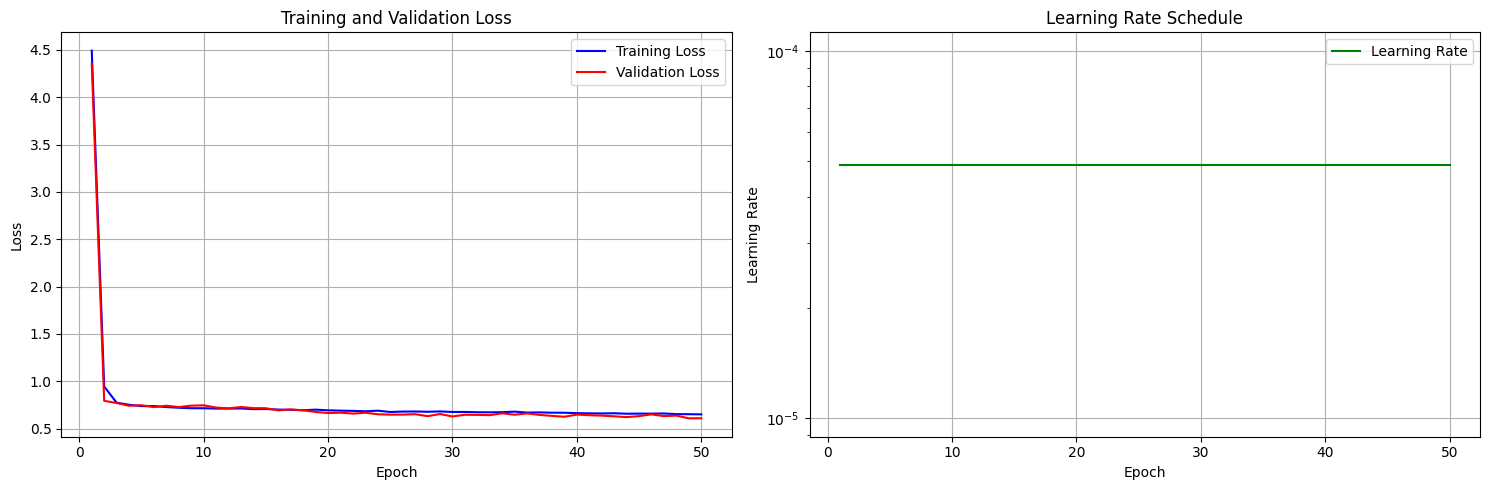

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(trainer.train_losses) + 1)
ax1.plot(epochs, trainer.train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, trainer.val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

learning_rates = [optimizer.param_groups[0]['lr'] for _ in epochs]
ax2.plot(epochs, learning_rates, 'g-', label='Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.legend()
ax2.grid(True)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [15]:
class ChiliDiseasePredictor:
    def __init__(self, model_path, category_names, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.category_names = category_names
        self.idx_to_class = {idx: name for idx, name in enumerate(['background'] + list(category_names.values()))}
        
        # Load model
        checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
        self.model = create_enhanced_maskrcnn(
            num_classes=len(category_names) + 1,
            backbone_type='resnet50',
            weights=None
        )
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        self.transforms = get_val_transforms()
        print("Model loaded successfully!")
    
    def predict(self, image_path, confidence_threshold=0.7):
        image = Image.open(image_path).convert('RGB')
        image_array = np.array(image)
        
        transformed = self.transforms(image=image_array)
        input_tensor = transformed['image'].unsqueeze(0).to(self.device)

        with torch.no_grad():
            predictions = self.model(input_tensor)
        
        pred = predictions[0]
        
        keep = pred['scores'] >= confidence_threshold
        
        boxes = pred['boxes'][keep].cpu().numpy()
        labels = pred['labels'][keep].cpu().numpy()
        scores = pred['scores'][keep].cpu().numpy()
        masks = pred['masks'][keep].cpu().numpy()
        
        return {
            'image_path': image_path,
            'image': image_array,
            'boxes': boxes,
            'labels': labels,
            'scores': scores,
            'masks': masks,
            'num_detections': len(boxes)
        }
    
    def visualize_prediction(self, image_path, confidence_threshold=0.7):
        result = self.predict(image_path, confidence_threshold)
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 12))
        ax.imshow(result['image'])
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(self.category_names)))
        class_colors = {class_name: colors[i] for i, class_name in enumerate(self.category_names.values())}
        
        for i, (box, label, score, mask) in enumerate(zip(
            result['boxes'], result['labels'], result['scores'], result['masks']
        )):
            x1, y1, x2, y2 = box
            class_name = self.idx_to_class.get(label, f'Class_{label}')
            color = class_colors.get(class_name, 'red')
            

            rect = plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                fill=False, color=color, linewidth=3
            )
            ax.add_patch(rect)

            mask_binary = (mask[0] > 0.5).astype(np.uint8)
            colored_mask = np.zeros_like(result['image'])
            colored_mask[mask_binary == 1] = np.array(color[:3]) * 255
            ax.imshow(colored_mask, alpha=0.3)
            
            label_text = f"{class_name}: {score:.2f}"
            ax.text(
                x1, y1-10, label_text,
                bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.8),
                fontsize=12, color='white', weight='bold'
            )
        
        ax.set_title(f'Chili Disease Detection - {result["num_detections"]} detections')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
        return result

predictor = ChiliDiseasePredictor('./checkpoints/best_model.pth', CATEGORY_NAMES)

d:\DS_repo\Sweet-Chili\global-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DS_repo\Sweet-Chili\global-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


C:\Users\worka\AppData\Local\Temp\ipykernel_3816\2559712428.py:39: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=1000, min_width=1000, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),


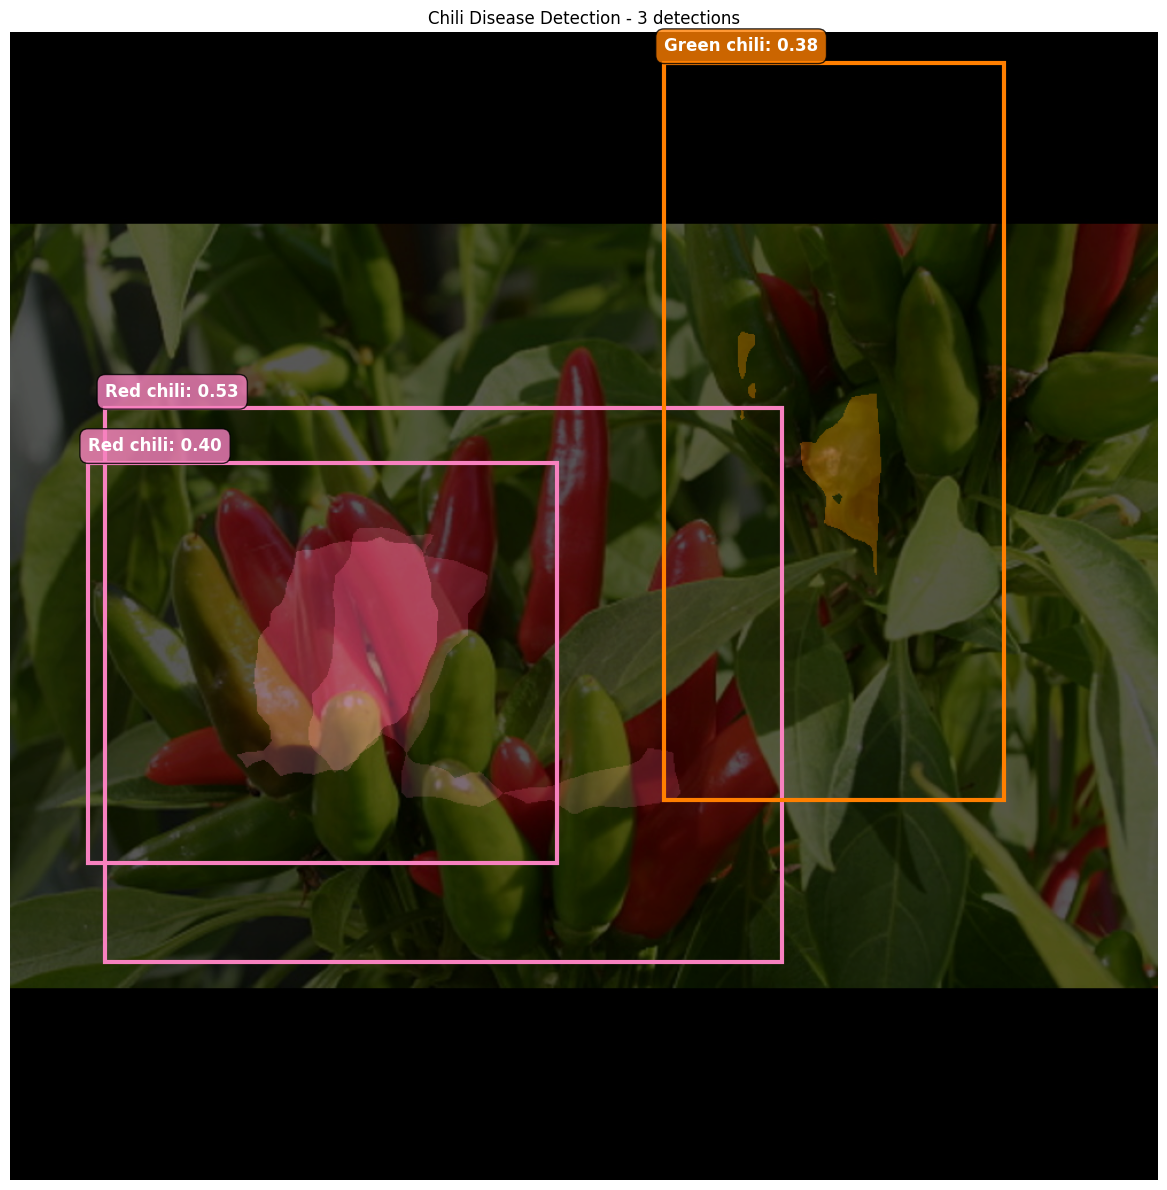

Detected 3 objects:
  1. Red chili: 0.532
  2. Red chili: 0.396
  3. Green chili: 0.377


In [19]:
# predictor = ChiliDiseasePredictor('D:/DS_repo/Sweet-Chili/models/exported_model/best_model.pth', CATEGORY_NAMES)

test_image_path = "C:/Users/worka/Pictures/scrap-img/chili-a.jpg"

try:
    result = predictor.visualize_prediction(test_image_path, confidence_threshold=0.3)
    
    print(f"Detected {result['num_detections']} objects:")
    for i, (label, score) in enumerate(zip(result['labels'], result['scores'])):
        class_name = predictor.idx_to_class.get(label, f'Class_{label}')
        print(f"  {i+1}. {class_name}: {score:.3f}")
        
except FileNotFoundError:
    print("Please update 'test_image_path' with a valid image path")
except Exception as e:
    print(f"Error during prediction: {e}")

In [20]:
def batch_test_images(image_directory, predictor, confidence_threshold=0.5):
    """Test on multiple images in a directory"""
    import glob
    
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(image_directory, ext)))
        image_paths.extend(glob.glob(os.path.join(image_directory, ext.upper())))
    
    if not image_paths:
        print(f"No images found in {image_directory}")
        return
    
    print(f"Found {len(image_paths)} images. Processing...")
    
    results_summary = {class_name: 0 for class_name in CATEGORY_NAMES.values()}
    total_detections = 0
    
    for i, image_path in enumerate(image_paths[:5]):  # Test first 5 images
        print(f"\nProcessing {i+1}/{min(5, len(image_paths))}: {os.path.basename(image_path)}")
        
        try:
            result = predictor.predict(image_path, confidence_threshold)
            total_detections += result['num_detections']
            
            print(f"  Detections: {result['num_detections']}")
            
            for label, score in zip(result['labels'], result['scores']):
                class_name = predictor.idx_to_class.get(label, f'Class_{label}')
                if class_name in results_summary:
                    results_summary[class_name] += 1
                print(f"    - {class_name}: {score:.3f}")
                
        except Exception as e:
            print(f"  Error: {e}")
    
    print(f"\n{'='*50}")
    print("BATCH TESTING SUMMARY")
    print(f"{'='*50}")
    print(f"Total detections: {total_detections}")
    print("Class distribution:")
    for class_name, count in results_summary.items():
        if count > 0:
            print(f"  {class_name}: {count}")

# Example usage (uncomment and modify path):
# batch_test_images("path/to/test/images/", predictor, confidence_threshold=0.5)

Analyzing model performance...


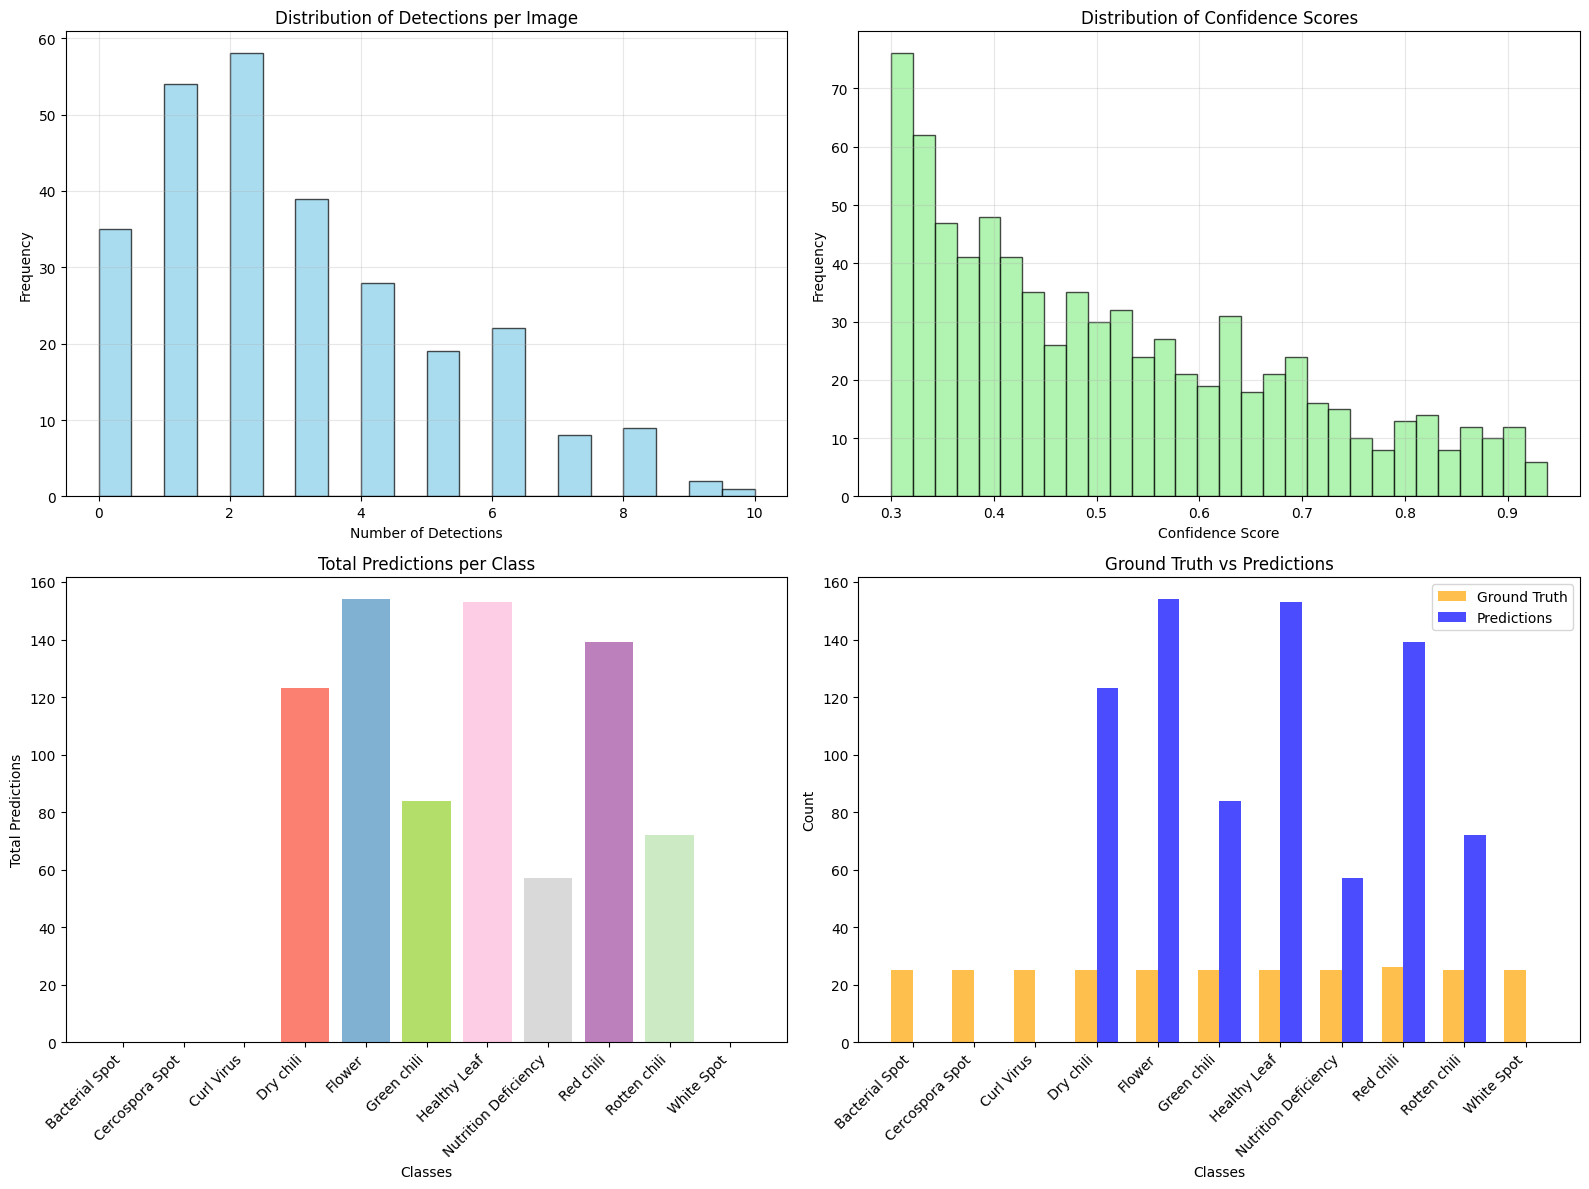


PERFORMANCE ANALYSIS SUMMARY
Analyzed 275 validation images
Average detections per image: 2.84
Average confidence score: 0.516
Confidence score std: 0.170

Class-wise analysis:
  Bacterial Spot:
    Ground Truth: 25
    Predictions: 0
    Approx Recall: 0.000
  Cercospora Spot:
    Ground Truth: 25
    Predictions: 0
    Approx Recall: 0.000
  Curl Virus:
    Ground Truth: 25
    Predictions: 0
    Approx Recall: 0.000
  Dry chili:
    Ground Truth: 25
    Predictions: 123
    Approx Recall: 1.000
  Flower:
    Ground Truth: 25
    Predictions: 154
    Approx Recall: 1.000
  Green chili:
    Ground Truth: 25
    Predictions: 84
    Approx Recall: 1.000
  Healthy Leaf:
    Ground Truth: 25
    Predictions: 153
    Approx Recall: 1.000
  Nutrition Deficiency:
    Ground Truth: 25
    Predictions: 57
    Approx Recall: 1.000
  Red chili:
    Ground Truth: 26
    Predictions: 139
    Approx Recall: 1.000
  Rotten chili:
    Ground Truth: 25
    Predictions: 72
    Approx Recall: 1.000
  W

In [21]:
def analyze_model_performance(predictor, val_dataset, num_samples=50):
    """Analyze model performance on validation set"""
    
    print("Analyzing model performance...")
    
    # Sample random images from validation set
    sample_indices = random.sample(range(len(val_dataset)), min(num_samples, len(val_dataset)))
    
    class_predictions = {class_name: [] for class_name in CATEGORY_NAMES.values()}
    class_ground_truth = {class_name: [] for class_name in CATEGORY_NAMES.values()}
    
    confidence_scores = []
    detection_counts = []
    
    for idx in sample_indices:
        # Get ground truth
        _, target = val_dataset[idx]
        gt_labels = target['labels'].numpy()
        
        # Get image path for prediction
        img_info = val_dataset.images[idx]
        img_path = os.path.join(val_dataset.img_dir, img_info['file_name'])
        
        try:
            # Make prediction
            result = predictor.predict(img_path, confidence_threshold=0.3)
            
            detection_counts.append(result['num_detections'])
            confidence_scores.extend(result['scores'].tolist())
            
            # Count ground truth classes
            for gt_label in gt_labels:
                if gt_label > 0:  # Skip background
                    class_name = list(CATEGORY_NAMES.values())[gt_label-1]
                    class_ground_truth[class_name].append(1)
            
            # Count predicted classes
            pred_class_counts = {class_name: 0 for class_name in CATEGORY_NAMES.values()}
            for pred_label in result['labels']:
                if pred_label > 0:
                    class_name = predictor.idx_to_class.get(pred_label, 'Unknown')
                    if class_name in pred_class_counts:
                        pred_class_counts[class_name] += 1
            
            for class_name, count in pred_class_counts.items():
                class_predictions[class_name].append(count)
                
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    
    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Detection count distribution
    axes[0,0].hist(detection_counts, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution of Detections per Image')
    axes[0,0].set_xlabel('Number of Detections')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].grid(True, alpha=0.3)
    
    # Confidence score distribution
    axes[0,1].hist(confidence_scores, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,1].set_title('Distribution of Confidence Scores')
    axes[0,1].set_xlabel('Confidence Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].grid(True, alpha=0.3)
    
    # Class prediction frequency
    class_names = list(CATEGORY_NAMES.values())
    pred_totals = [sum(class_predictions[name]) for name in class_names]
    
    axes[1,0].bar(range(len(class_names)), pred_totals, color=plt.cm.Set3(np.linspace(0, 1, len(class_names))))
    axes[1,0].set_title('Total Predictions per Class')
    axes[1,0].set_xlabel('Classes')
    axes[1,0].set_ylabel('Total Predictions')
    axes[1,0].set_xticks(range(len(class_names)))
    axes[1,0].set_xticklabels(class_names, rotation=45, ha='right')
    
    # Ground truth vs predictions comparison
    gt_totals = [sum(class_ground_truth[name]) for name in class_names]
    
    x = np.arange(len(class_names))
    width = 0.35
    
    axes[1,1].bar(x - width/2, gt_totals, width, label='Ground Truth', alpha=0.7, color='orange')
    axes[1,1].bar(x + width/2, pred_totals, width, label='Predictions', alpha=0.7, color='blue')
    axes[1,1].set_title('Ground Truth vs Predictions')
    axes[1,1].set_xlabel('Classes')
    axes[1,1].set_ylabel('Count')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("PERFORMANCE ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Analyzed {len(sample_indices)} validation images")
    print(f"Average detections per image: {np.mean(detection_counts):.2f}")
    print(f"Average confidence score: {np.mean(confidence_scores):.3f}")
    print(f"Confidence score std: {np.std(confidence_scores):.3f}")
    
    print("\nClass-wise analysis:")
    for class_name in class_names:
        gt_count = sum(class_ground_truth[class_name])
        pred_count = sum(class_predictions[class_name])
        print(f"  {class_name}:")
        print(f"    Ground Truth: {gt_count}")
        print(f"    Predictions: {pred_count}")
        if gt_count > 0:
            recall_approx = min(1.0, pred_count / gt_count)
            print(f"    Approx Recall: {recall_approx:.3f}")

# Run performance analysis
analyze_model_performance(predictor, val_dataset, num_samples=275)

In [22]:
def export_model_for_production(model_path, export_dir="./exported_model"):
    """Export model and create deployment package"""
    
    os.makedirs(export_dir, exist_ok=True)
    
    # Copy the model checkpoint
    import shutil
    shutil.copy(model_path, os.path.join(export_dir, "best_model.pth"))
    
    # Save category names
    with open(os.path.join(export_dir, "category_names.json"), 'w') as f:
        json.dump(CATEGORY_NAMES, f, indent=2)
    
    # Create a simple inference script
    inference_script = '''
import torch
import numpy as np
from PIL import Image
import json
import os

# Load this script alongside the model for easy inference
class ChiliPredictor:
    def __init__(self, model_path, category_file):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Load categories
        with open(category_file, 'r') as f:
            self.category_names = json.load(f)
        
        # Load model (you'll need to include the model creation code)
        checkpoint = torch.load(model_path, map_location=self.device)
        # ... model loading code ...
        
    def predict(self, image_path, confidence_threshold=0.7):
        # ... prediction code ...
        pass

# Usage:
# predictor = ChiliPredictor("best_model.pth", "category_names.json")
# result = predictor.predict("image.jpg")
'''
    
    with open(os.path.join(export_dir, "inference_template.py"), 'w') as f:
        f.write(inference_script)
    
    # Create README
    readme_content = f'''
# Chili Disease Detection Model

## Model Information
- Architecture: Mask R-CNN with EfficientNet-B3 backbone
- Classes: {len(CATEGORY_NAMES)} disease/condition classes
- Input Size: 1000x1000 pixels
- Framework: PyTorch

## Files
- `best_model.pth`: Trained model weights
- `category_names.json`: Class name mapping
- `inference_template.py`: Template for inference code

## Usage
1. Load the model using the checkpoint
2. Preprocess images to 1000x1000 with proper normalization
3. Run inference and apply confidence thresholding
4. Post-process results for visualization

## Classes
{chr(10).join([f"{i}. {name}" for i, name in enumerate(CATEGORY_NAMES.values(), 1)])}

## Performance Notes
- Best validation loss achieved during training
- Optimized for agricultural disease detection
- Handles class imbalance with advanced training techniques
'''
    
    with open(os.path.join(export_dir, "README.md"), 'w') as f:
        f.write(readme_content)
    
    print(f"Model exported to: {export_dir}")
    print("Files created:")
    for file in os.listdir(export_dir):
        print(f"  - {file}")

# Export the trained model
export_model_for_production("./checkpoints/best_model.pth")

Model exported to: ./exported_model
Files created:
  - best_model.pth
  - category_names.json
  - inference_template.py
  - README.md
